# 1D MT inversion: L2 (MSE) and OT (Sinkhorn)

**What this notebook does**  
Runs **both L2 (MSE)** and **OT (Sinkhorn)** 1D MT inversion on the same true model and synthetic data. Demonstrates how L2 vs OT data loss compare under identical setup.

**Usage (after `pip install -e .`)**  
Run all cells. No extra path setup needed when the package is installed.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# Path setup: works when installed (pip install -e .) or run from repo
try:
    from mt1d_inv import MT1D, MT1DInverter
except ImportError:
    _root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
    if _root not in sys.path:
        sys.path.insert(0, _root)
    from mt1d_inv import MT1D, MT1DInverter

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Shared true model (6-layer) for both L2 and OT
dz_true = [600, 600, 600, 600, 600]
sig_true = [0.1, 0.08, 0.3, 0.05, 0.01, 0.005]
my_model = MT1D(dz_true, sig_true)
print("True model: dz =", dz_true, ", sig =", sig_true)

In [2]:
## 1. L₂ (MSE) inversion

Using device: cpu
Parameterization: 对数参数空间
Using 3D Sinkhorn loss function
[Constraint Setup]
  - Occam Constraint: True
  - Constraint Type: roughness
  - Reference Model Weight: 0.0


视电阻率误差范围: 0.6633 - 48.2332 Ω·m
相位误差: 2.86°
Generated synthetic data with 5.0% noise (gaussian)
  → Noise std in log10(rho): 0.0434
  → Noise std in normalized phase: 0.0500


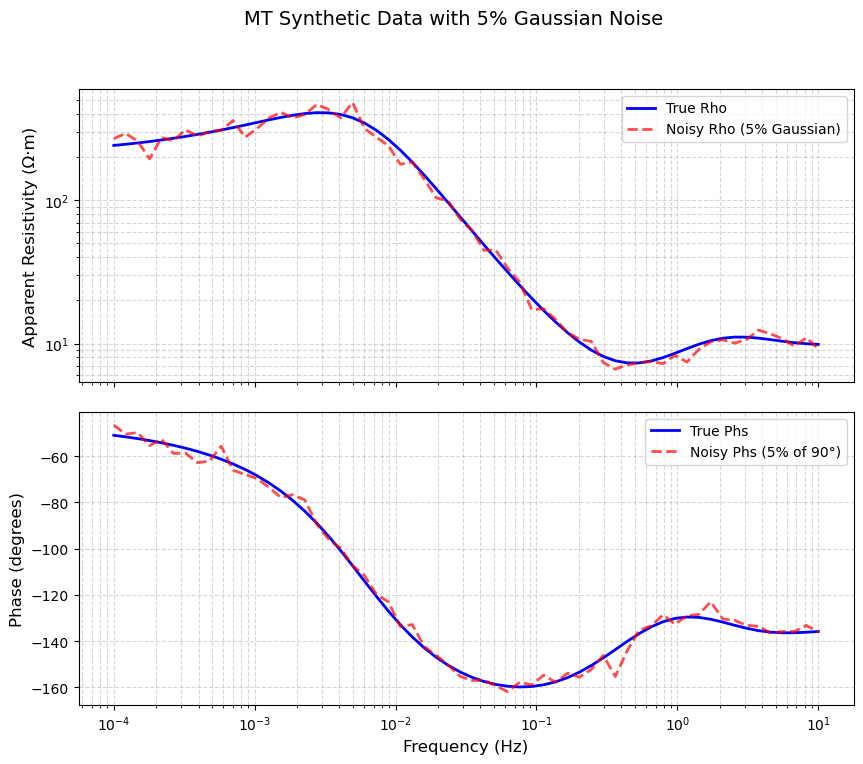

In [3]:
# L2 inverter (MSE mode)
inv_l2 = MT1DInverter(device=device, use_sinkhorn=False)
inv_l2.generate_synthetic_data(
    true_dz=my_model.dz,
    true_sig=my_model.sig,
    freq_range=(1, -4),
    n_freq=60,
    noise_level=0.05,
    seed=42
)
inv_l2.initialize_model(
    n_layers=20,
    total_depth=3000,
    initial_sig=0.1,
    thickness_mode="equal"
)
inv_l2.setup_constraints(use_occam_constraint=True, constraint_type="roughness")
inv_l2.setup_optimizer(lr=0.01, reg_weight_sig=0.1, p=2)

inv_l2.run_inversion(
    num_epochs=1000,
    print_interval=50,
    seed=42,
    track_chi2=True,
    enable_auto_stop=True,
    target_rms=1.05
)

In [4]:
# L2 results
inv_l2.plot_synthetic_data()
inv_l2.plot_data_fit()
inv_l2.plot_loss_history(target_misfit=1.0)
inv_l2.plot_model_comparison()
inv_l2.plot_chi2_history()
inv_l2.plot_gradient_history()
inv_l2.plot_sensitivity()

初始化对数电导率参数（Sinkhorn模式）
初始电导率: [0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582]
使用线性/幂次增长 (exponent=1.0)模式
初始化模型，共 20 层
累计深度: [15.789473533630371, 47.3684196472168, 94.7368392944336, 157.8947296142578, 236.84210205078125, 331.5789489746094, 442.1052551269531, 568.4210205078125, 710.5263061523438, 868.4210205078125, 1042.105224609375, 1231.578857421875, 1436.842041015625, 1657.8946533203125, 1894.73681640625, 2147.368408203125, 2415.78955078125, 2700.0, 3000.0]


In [5]:
## 2. OT (Sinkhorn) inversion

✓ 创建优化器: AdamW
  - 学习率: 0.06
  - 权重衰减: 0.0
✓ 创建Sinkhorn损失:
  - p范数: 2
  - blur: 0.1
  - scaling: 0.9
  - reach: None (平衡/质量守恒)
Using 3D Sinkhorn loss with p=2, blur=0.1, reach=None (balanced)
Optimizer setup: AdamW with lr=0.06, weight_decay=0.0
Regularization: sig_reg=0, phs_weight=0.5


In [6]:
# OT inverter (Sinkhorn mode)
inv_ot = MT1DInverter(device=device, use_sinkhorn=True, sinkhorn_dim=3)
inv_ot.generate_synthetic_data(
    true_dz=my_model.dz,
    true_sig=my_model.sig,
    freq_range=(1, -4),
    n_freq=60,
    noise_level=0.05,
    seed=42
)
inv_ot.initialize_model(
    n_layers=20,
    total_depth=3000,
    initial_sig=0.01,
    thickness_mode="equal"
)
inv_ot.setup_constraints(use_occam_constraint=True, constraint_type="roughness")
inv_ot.setup_optimizer(
    lr=0.05,
    reg_weight_sig=0.0001,
    optimizer_type="AdamW",
    weight_decay=0.01,
    betas=(0.9, 0.999)
)
inv_ot.set_reference_model([0.01] * 10, weight=0.01)

inv_ot.run_inversion(
    num_epochs=3000,
    print_interval=50,
    seed=42,
    track_chi2=True,
    enable_auto_stop=True,
    target_rms=1.05
)

[Info] Random seed = 42

Starting inversion for 700 epochs...
Adaptive Lambda: True
Occam Constraint: True
Constraint Type: roughness
Epoch 20/700 [   2.9%]
  已用时间: 0:00:14 | 剩余时间: ~0:08:00 | ETA: 23:28:55
  Epoch耗时: 0.78s | 平均耗时: 0.71s
  Total: 8.7890e-01 | Data(Sinkhorn): 8.7835e-01
  Misfit(RMS χ²): 30.507 | Rough: 5.48e-03 | Lam: 0.1000000
  GradNorms: |g_d|=5.918e-02 | |g_m|=2.063e-02
Epoch 40/700 [   5.7%]
  已用时间: 0:00:28 | 剩余时间: ~0:07:50 | ETA: 23:29:00
  Epoch耗时: 0.79s | 平均耗时: 0.71s
  Total: 9.8867e-02 | Data(Sinkhorn): 8.3793e-02
  Misfit(RMS χ²): 8.232 | Rough: 1.51e-01 | Lam: 0.1000000
  GradNorms: |g_d|=1.880e-02 | |g_m|=9.777e-02
Epoch 60/700 [   8.6%]
  已用时间: 0:00:43 | 剩余时间: ~0:07:40 | ETA: 23:29:05
  Epoch耗时: 0.80s | 平均耗时: 0.72s
  Total: 4.0649e-02 | Data(Sinkhorn): 3.2229e-02
  Misfit(RMS χ²): 6.070 | Rough: 2.17e-01 | Lam: 0.0388749
  GradNorms: |g_d|=6.917e-03 | |g_m|=8.992e-02
Epoch 80/700 [  11.4%]
  已用时间: 0:00:57 | 剩余时间: ~0:07:27 | ETA: 23:29:06
  Epoch耗时: 0.80s | 

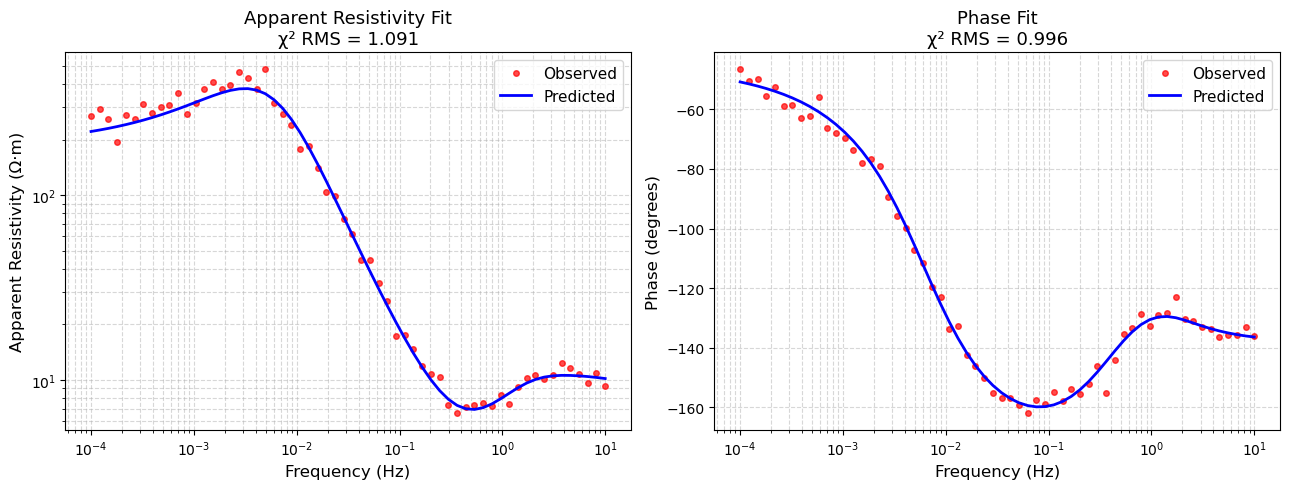

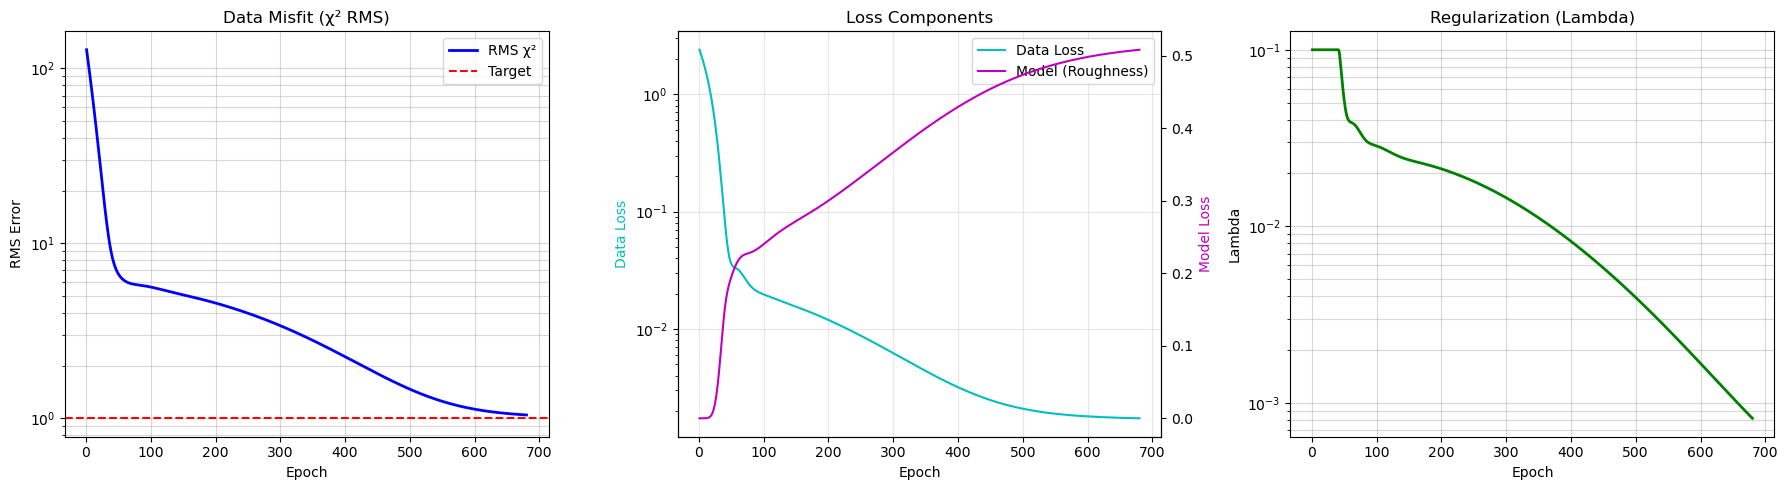

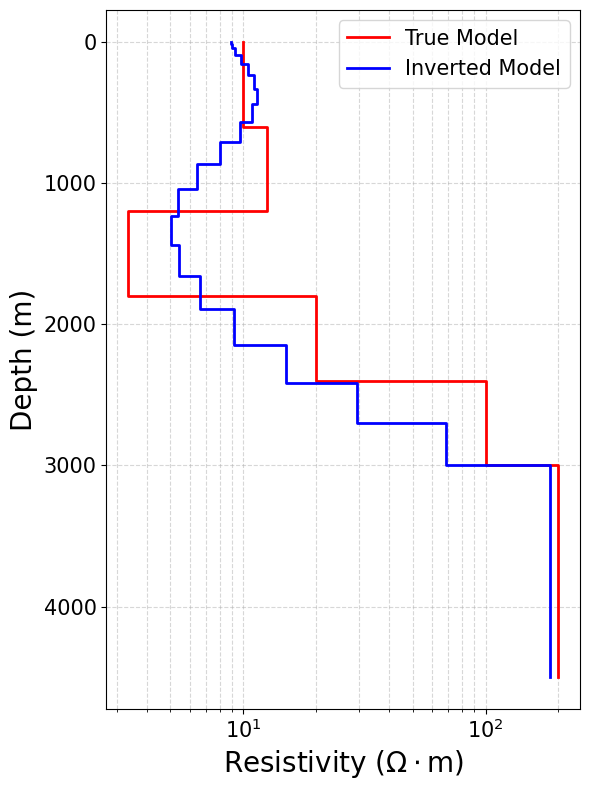

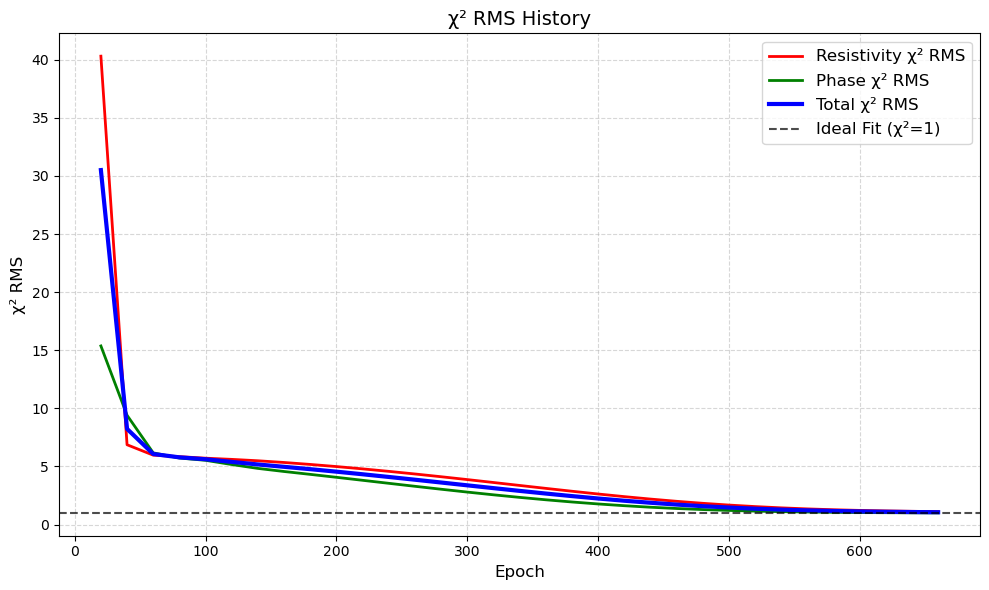

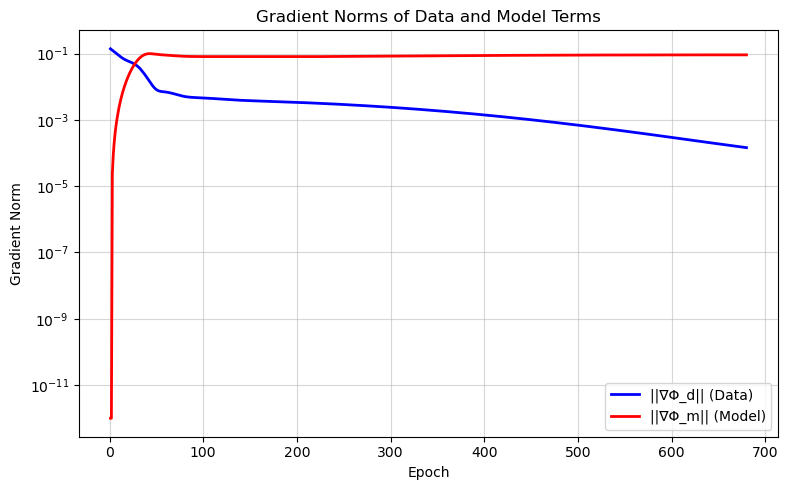

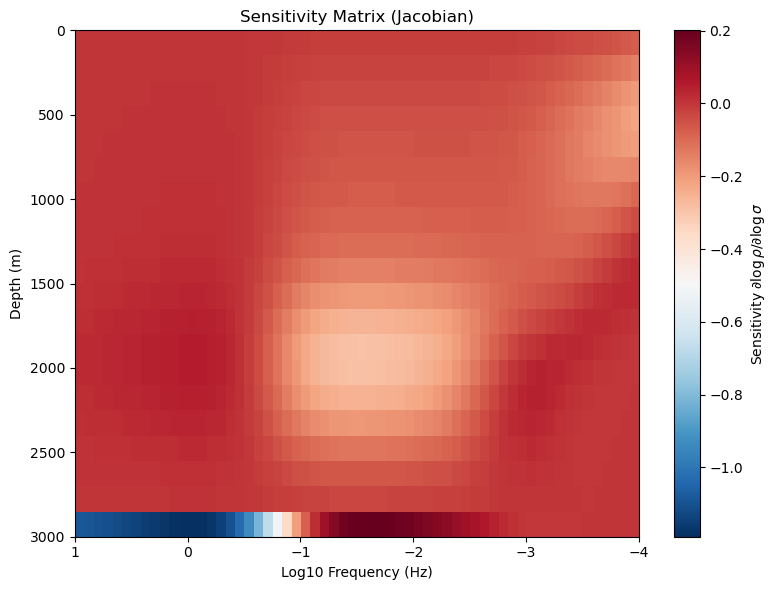

In [7]:
# OT results
inv_ot.plot_synthetic_data()
inv_ot.plot_data_fit()
inv_ot.plot_loss_history(target_misfit=1.0)
inv_ot.plot_model_comparison()
inv_ot.plot_chi2_history()
inv_ot.plot_gradient_history()
inv_ot.plot_sensitivity()
